[注意力分数](https://www.bilibili.com/video/BV1Tb4y167rb/?spm_id_from=333.788.recommend_more_video.0&vd_source=1d3a7b81d826789081d8b6870d4fff8e)

<img src="picture/截屏2022-06-21 14.24.03.png">

- α（x,xi）：注意力权重（权重一般是一组大于等于零，相加和为 1 的数）
- 注意力分数：高斯核的指数部分（相当于是注意力权重归一化之前的版本）
- 上图所展示的是：假设已知一些 key-value 对和一个 query，首先将 query 和每一个 key 通过注意力分数函数 a 和 softmax 运算得到注意力权重（与 key 对应的值的概率分布），将这些注意力权重再与已知的 value 进行加权求和，最终就得到了输出
- 这张图里面的a为$-\frac{1}{2}(x-x_i)^2 y_i$,但是显然a可以有多种写法

<img src="picture/截屏2022-06-21 15.52.41.png">

此图也可以看出关键在于如何设计$a(q,k_i)$

<img src='picture/截屏2022-06-21 16.02.29.png'>

- 第一种设计思路:可加注意力层
- 可学参数$W_k,W_q,v$

<img src="picture/截屏2022-06-21 16.36.00.png">

- 使用点积可以得到计算效率更高i的评分函数，但是点积操作要求 query 和 key 具有相同的长度
- 假设 query 和 key 的所有元素都是独立的随机变量，并且都满足零均值和单位方差，那么两个向量的点积的均值为 0 ，方差为 d
- 这里不需要学习任何东西，直接利用 $<q,k_i>$ 将 q 和 $k_i$ 做内积然后除以根号 d （除以根号 d 的目的是为了降低对 ki 的长度的敏感度，使得无论向量的长度如何，点积的方差在不考虑向量长度的情况下仍然是 1 ）



1. 注意力分数是 query 和 key 的相似度（没有经过 normalize ），注意力权重是注意力分数的 softmax 结果（ 0 到 1 之间的数）
2. 两种常见的注意力分数的计算
- 有参数的版本：将 query 和 key 合并起来进入一个单隐藏层单输出的 MLP（在 query 和 key 向量长度不同的情况下）
- 无参数的版本：直接将 query 和 key 做内积（在 query 和 key 向量长度一定的情况下），效率更高

In [34]:

import math
import torch
from torch import nn
from torch.nn import functional
from d2l import torch as d2l

In [35]:

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return functional.softmax(X.reshape(shape), dim=-1)

In [36]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4868, 0.5132, 0.0000, 0.0000],
         [0.5626, 0.4374, 0.0000, 0.0000]],

        [[0.3478, 0.3242, 0.3281, 0.0000],
         [0.4298, 0.2694, 0.3008, 0.0000]]])

In [37]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3457, 0.3041, 0.3502, 0.0000]],

        [[0.4400, 0.5600, 0.0000, 0.0000],
         [0.2108, 0.1812, 0.2918, 0.3162]]])

加性注意力（additive attention）的评分函数为

$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$

In [38]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 使用unsqueeze进行维度扩展后，见附录10
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(dim=2) + keys.unsqueeze(dim=1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1) # 理解了升维,降维就很好理解了
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [39]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

In [40]:

# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

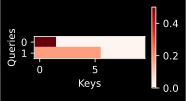

In [41]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [42]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [43]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

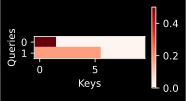

In [44]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')